In [38]:
import jax.numpy as np
import jax

import numpy as onp

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors

In [47]:
def rosen(x):
    # Equation 2.22
    x_1, x_2 = x[0], x[1]
    return 100 * (x_2 - x_1**2)**2 + (1 - x_1)**2

rosen = np.vectorize(rosen, signature='(k)->()')

grad_rosen = jax.grad(rosen)
#vgrad_rosen = np.vectorize(grad_rosen, signature='(k)->(k)')

hess_rosen = jax.hessian(rosen)
#vhess_rosen = np.vectorize(hess_rosen, signature='(k)->(k,k)')

def hessp_rosen(x, p):
    #print(f'calling hessp with x: {x} p: {p}')
    return hess_rosen(x) @ p

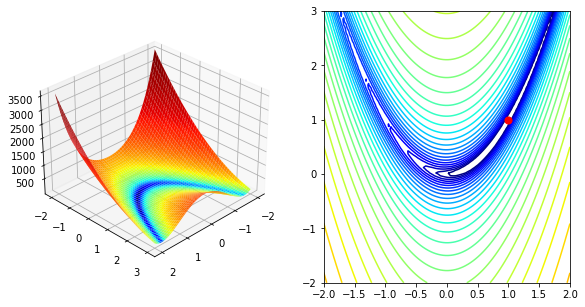

In [48]:
def plot_rosen(steps=None, step_sizes=None):
    x = np.linspace(-2, 2, 100)
    y = np.linspace(-2, 3, 100)
    xx, yy = np.meshgrid(x, y, indexing='ij')
    points = np.stack((xx, yy), axis=2)

    plt.figure(figsize=(15, 5))
    ax = plt.gcf().add_subplot(131, projection='3d')
    ax.plot_surface(xx, yy, rosen(points), cmap=cm.jet, norm=colors.LogNorm())
    ax.view_init(30, 45)

    ax = plt.gcf().add_subplot(132)
    ax.contour(xx, yy, rosen(points), levels=np.logspace(0, 5, 35), norm=colors.LogNorm(), cmap=cm.jet)
    ax.scatter([1.], [1.], s=50, c='r', zorder=100)

    if steps is not None:
        ax.scatter(steps[:, 0], steps[:, 1], c='black', s=40, zorder=99)

    if step_sizes is not None:
        ax = plt.gcf().add_subplot(133)
        ax.plot(step_sizes)

plot_rosen()

In [98]:
def newtoncg(f, grad, hessp, x0, xtol=1e-5, maxiter=None):
    # Adapted from scipy source code
    # https://github.com/scipy/scipy/blob/d78daa50c2d462c32b62cfa8cd4bb03b5d9b1403/scipy/optimize/optimize.py#L1681
    # Variable names match Nocedal and Wright 2nd Edition Algorithm 7.1 (Line Search Newton-CG)
    # Currently uses very simple backtracking line search

    nparams = x0.shape[0]
    
    if maxiter is None:
        maxiter = nparams * 200
    cg_maxiter = nparams * 20
    
    xtol = nparams * xtol
    update = np.array([2 * xtol])
    x_k = x0
    
    k = 0
    float32eps = np.finfo(np.float32).eps
    
    while np.linalg.norm(update, ord=1) > xtol:
        if k >= maxiter:
            print('Maximum iterations reached. Terminating.')
            return x_k
        
        # Compute a search direction pk by applying the CG method to
        # def2 f(x_k) p = - grad f(x_k) starting from 0.
        b = -grad(x_k)
        maggrad = np.linalg.norm(b, ord=1)
        eta = np.min(np.asarray([0.5, np.sqrt(maggrad)]))
        termcond = eta * maggrad
        z_i = np.zeros_like(x0)
        
        r_i = -b
        d_i = -r_i
        riri_0 = r_i.T @ r_i
        i = 0
        
        print(f'currently at {x_k}')
        for k2 in range(cg_maxiter):
            if np.linalg.norm(r_i, ord=1) <= termcond:
                break
            #print(f'norm is {np.linalg.norm(r_i, ord=1)}')
            Ap = hessp(x_k, d_i)
            curv = d_i.T @ Ap
            if 0 <= curv <= 3 * float32eps:
                break
            elif curv < 0:
                if i > 0:
                    break
                else:
                    z_i = riri_0 / (-curv) * b
                    break
            
            alpha_i = riri_0 / curv
            z_i = z_i + alpha_i * d_i
            r_i = r_i + alpha_i * Ap
            riri_1 = r_i.T @ r_i
            beta_i = riri_1 / riri_0
            d_i = -r_i + beta_i * d_i
            riri_0 = riri_1
            i += 1
        else:
            print('CG did not converge. Hessian not positive definite.')
            return None
        pk = z_i

        # Line search with simple backtracking
        # TODO(doktay): Something fancy
        a_i = 1.0
        c_1 = 1e-4
        rho = 0.1

        slope = (-b).T @ pk
        f_k = f(x_k)
        while f(x_k + a_i * pk) > f_k + c_1 * a_i * slope:
            a_i = a_i * rho

        update = a_i * pk
        x_k = x_k + update
        k += 1
    return x_k

In [66]:
x = newtoncg(rosen, grad_rosen, hessp_rosen, np.array([-1.2, 1]))

In [105]:
def newtoncg_lax(f, grad, hessp, x0, xtol=1e-5, maxiter=None):
    # Adapted from Scipy source code
    # https://github.com/scipy/scipy/blob/d78daa50c2d462c32b62cfa8cd4bb03b5d9b1403/scipy/optimize/optimize.py#L1681
    # Variable names match Nocedal and Wright 2nd Edition Algorithm 7.1 (Line Search Newton-CG)
    # Currently uses very simple backtracking line search

    nparams = x0.shape[0]
    
    if maxiter is None:
        maxiter = nparams * 200
    cg_maxiter = nparams * 20
    
    xtol = nparams * xtol
    update = np.ones_like(x0) * 2 * xtol
    x_k = x0
    
    k = 0
    float32eps = np.finfo(np.float32).eps
    
    def loop_cond(val):
        k, x_k, update = val
        return np.linalg.norm(update, ord=1) > xtol
    
    def loop_body(val):
        k, x_k, update = val
        
        # Compute a search direction pk by applying the CG method to
        # def2 f(x_k) p = - grad f(x_k) starting from 0.
        b = -grad(x_k)
        maggrad = np.linalg.norm(b, ord=1)
        eta = np.min(np.asarray([0.5, np.sqrt(maggrad)]))
        termcond = eta * maggrad
        z_i = np.zeros_like(x0)
        
        r_i = -b
        d_i = -r_i
        riri_0 = r_i.T @ r_i
        i = 0
        
        def cg_cond(val):
            term, i, x_k, z_i, r_i, d_i, riri_0 = val
            return np.logical_not(term)

        def cg_iteration(val):
            term, i, x_k, z_i, r_i, d_i, riri_0 = val

            Ap = hessp(x_k, d_i)
            curv = d_i.T @ Ap

            def normal_iter(iter_val):
                Ap, curv, i, x_k, z_i, r_i, d_i, riri_0 = iter_val

                alpha_i = riri_0 / curv
                z_i1 = z_i + alpha_i * d_i
                r_i1 = r_i + alpha_i * Ap
                riri_1 = r_i1.T @ r_i1
                beta_i = riri_1 / riri_0
                d_i1 = -r_i1 + beta_i * d_i
                return (False, i+1, x_k, z_i1, r_i1, d_i1, riri_1)

            def update_break(iter_val):
                Ap, curv, i, x_k, z_i, r_i, d_i, riri_0 = iter_val

                z_i = riri_0 / (-curv) * b
                return (True, i, x_k, z_i, r_i, d_i, riri_0)

            return jax.lax.cond(
                        np.logical_or(
                            np.logical_or(
                                np.linalg.norm(r_i, ord=1) <= termcond,
                                np.logical_and(0 <= curv, curv <= 3 * float32eps)
                            ), np.logical_and(curv < 0, i > 0)),
                        lambda _: (True, i, x_k, z_i, r_i, d_i, riri_0),
                        lambda _: jax.lax.cond(
                            np.logical_and(curv < 0, i == 0),
                            update_break,
                            normal_iter,
                            operand=(Ap, curv, i, x_k, z_i, r_i, d_i, riri_0)
                        ),
                operand=(Ap, curv, i, x_k, z_i, r_i, d_i, riri_0)
            )

        val = jax.lax.while_loop(cg_cond, cg_iteration, (False, 0, x_k, z_i, r_i, d_i, riri_0))
        print(f'finished cg loop with term: {val[0]} i: {val[1]} x_k: {x_k}')
        
        pk = val[3]

        # Line search with simple backtracking
        # TODO(doktay): Something fancy
        a_i = 1.0
        c_1 = 1e-4
        rho = 0.1

        slope = (-b).T @ pk
        f_k = f(x_k)

        def ls_cond(a_i):
            return f(x_k + a_i * pk) > f_k + c_1 * a_i * slope
        
        def ls_body(a_i):
            return a_i * rho
        
        a_i = jax.lax.while_loop(ls_cond, ls_body, a_i)

        update = a_i * pk
        x_k = x_k + update

        return k + 1, x_k, update
    
    val = jax.lax.while_loop(loop_cond, loop_body, (0, x_k, update))
    return val[1]

In [108]:
x = newtoncg_lax(rosen, grad_rosen, hessp_rosen, np.array([-1.2, 1.]))

finished cg loop with term: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)> i: Traced<ShapedArray(int32[], weak_type=True)>with<DynamicJaxprTrace(level=1/0)> x_k: Traced<ShapedArray(float32[2])>with<DynamicJaxprTrace(level=1/0)>


In [110]:
x = newtoncg(rosen, grad_rosen, hessp_rosen, np.array([-1.2, 1.]))

currently at [-1.2  1. ]
currently at [-1.0566975  1.0584909]
currently at [-1.030894   1.0689491]
currently at [-1.0226012  1.0620975]
currently at [-1.0257236  1.0582463]
currently at [-1.0176728  1.0518014]
currently at [-1.0207151  1.0479283]
currently at [-1.0128767  1.0418434]
currently at [-1.0158464  1.0379448]
currently at [-1.0081965  1.0321821]
currently at [-1.0110991  1.0282546]
currently at [-1.0036178  1.022783 ]
currently at [-1.0064583  1.0188237]
currently at [-0.999129   1.0136179]
currently at [-1.0019114  1.009624 ]
currently at [-0.9947195  1.0046614]
currently at [-0.9974472  1.0006304]
currently at [-0.9903792  0.9958911]
currently at [-0.9930554  0.9918201]
currently at [-0.9861002   0.98728764]
currently at [-0.98872745  0.98317426]
currently at [-0.98187464  0.9788336 ]
currently at [-0.9844554   0.97467536]
currently at [-0.9776961  0.9705138]
currently at [-0.9802323  0.9663082]
currently at [-0.9735585   0.96231455]
currently at [-0.97605175  0.9580591 ]
c

In [109]:
x

DeviceArray([0.9999973, 0.9999946], dtype=float32)